In [4]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import datetime as dt
import copy
import os
from sklearn.linear_model import LinearRegression
import random
from datetime import timedelta

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score

In [5]:
wr_series = pd.read_csv('/glade/work/jhayron/Data4Predictability/WR_Series_20230824.csv',\
                index_col=0,names=['week0'],skiprows=1,parse_dates=True)
for wk in range(2,10):
    series_temp = copy.deepcopy(wr_series["week0"])
    series_temp.index = series_temp.index - timedelta(weeks = wk-1)
    series_temp.name = f'week{wk-1}'
    if wk==2:
        df_shifts = pd.concat([pd.DataFrame(wr_series["week0"]),pd.DataFrame(series_temp)],axis=1)  
    else:
        df_shifts = pd.concat([df_shifts,pd.DataFrame(series_temp)],axis=1)

In [6]:
acc_persistence = []
balanced_acc_persistence = []

for week in range(0,9):
    week_out_str = f'week{week}'
    df_temp = df_shifts[['week0',week_out_str]].dropna()
    acc_persistence.append(accuracy_score(df_temp.iloc[:,0],df_temp.iloc[:,1]))
    balanced_acc_persistence.append(balanced_accuracy_score(df_temp.iloc[:,0],df_temp.iloc[:,1]))

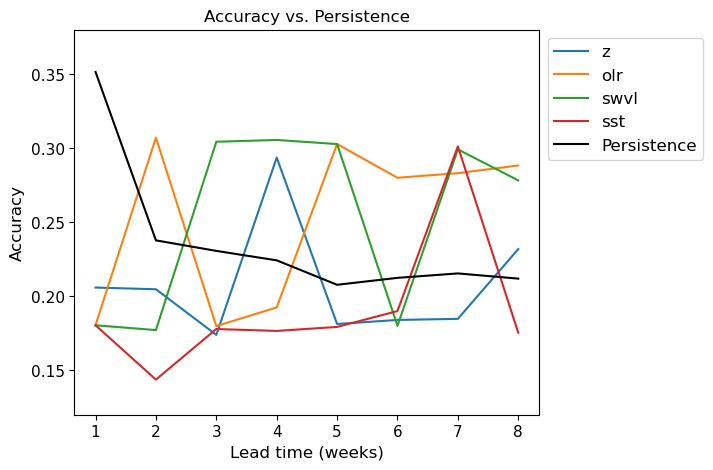

In [8]:
plt.figure(figsize=(6,5))

plt.plot(np.arange(1,9),np.load('acc_atm_z.npy')[1:],label='z')
plt.plot(np.arange(1,9),np.load('acc_atm_olr.npy')[1:],label='olr')
plt.plot(np.arange(1,9),np.load('acc_lnd_swvl.npy')[1:],label='swvl')
plt.plot(np.arange(1,9),np.load('acc_ocn_sst.npy')[1:],label='sst')
# plt.plot(np.arange(1,9),np.load('acc_atm.npy')[1:],label='atm')
# plt.plot(np.arange(1,9),np.load('acc_ocn.npy')[1:],label='ocn')
# plt.plot(np.arange(1,9),np.load('acc_lnd.npy')[1:],label='lnd')
plt.plot(np.arange(1,9),acc_persistence[1:],color='k',label='Persistence')

plt.legend(bbox_to_anchor=(1., 1.),fontsize=12)
plt.xlabel('Lead time (weeks)',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.ylim(0.12,0.38)
plt.title('Accuracy vs. Persistence')
plt.show()
plt.close('all')

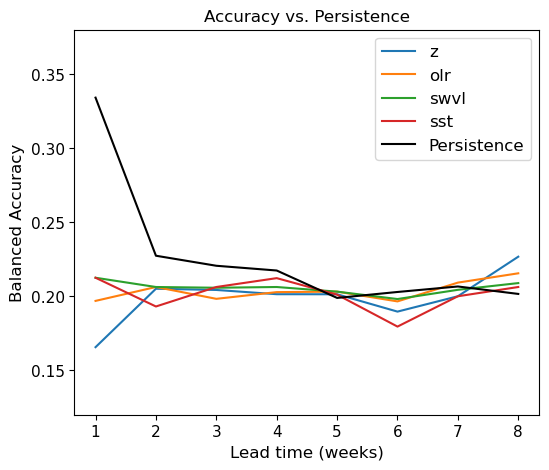

In [9]:
plt.figure(figsize=(6,5))

plt.plot(np.arange(1,9),np.load('balanced_acc_atm_z.npy')[1:],label='z')
plt.plot(np.arange(1,9),np.load('balanced_acc_atm_olr.npy')[1:],label='olr')
plt.plot(np.arange(1,9),np.load('balanced_acc_lnd_swvl.npy')[1:],label='swvl')
plt.plot(np.arange(1,9),np.load('balanced_acc_ocn_sst.npy')[1:],label='sst')
# plt.plot(np.arange(1,9),np.load('acc_atm.npy')[1:],label='atm')
# plt.plot(np.arange(1,9),np.load('acc_ocn.npy')[1:],label='ocn')
# plt.plot(np.arange(1,9),np.load('acc_lnd.npy')[1:],label='lnd')
plt.plot(np.arange(1,9),balanced_acc_persistence[1:],color='k',label='Persistence')

plt.legend(bbox_to_anchor=(1., 1.),fontsize=12)
plt.xlabel('Lead time (weeks)',fontsize=12)
plt.ylabel('Balanced Accuracy',fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.ylim(0.12,0.38)
plt.title('Accuracy vs. Persistence')
plt.show()
plt.close('all')

# Accuracy for different seasons

In [14]:
acc_persistence_seasons = []

for week in range(0,9):
    week_out_str = f'week{week}'
    df_temp = df_shifts[['week0',week_out_str]].dropna()
    acc_temp = []
    for seasoni in [0,1,2,3]: ## winter, spring, summer, fall
        if seasoni == 0:
            where_season = (df_temp.index.month==1)|(df_temp.index.month==2)|(df_temp.index.month==3)
        elif seasoni == 1:
            where_season = (df_temp.index.month==4)|(df_temp.index.month==5)|(df_temp.index.month==6)
        elif seasoni == 2:
            where_season = (df_temp.index.month==7)|(df_temp.index.month==8)|(df_temp.index.month==9)
        elif seasoni == 3:
            where_season = (df_temp.index.month==10)|(df_temp.index.month==11)|(df_temp.index.month==12)
        df_temp_season = df_temp.loc[where_season]
        acc_temp.append(balanced_accuracy_score(df_temp_season.iloc[:,0],df_temp_season.iloc[:,1]))
    acc_persistence_seasons.append(acc_temp)
acc_persistence_seasons = np.array(acc_persistence_seasons)

(0.15, 0.4)

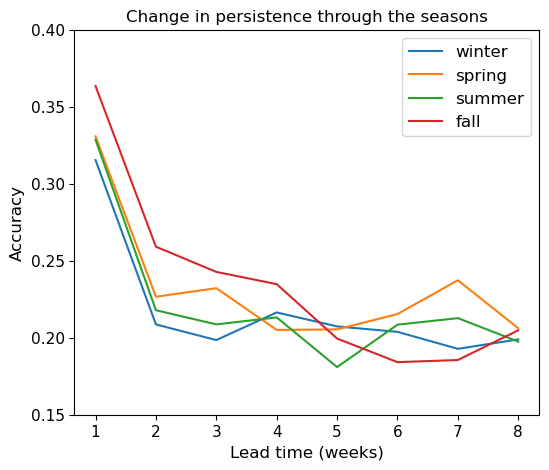

In [15]:
plt.figure(figsize=(6,5))

plt.plot(np.arange(1,9),acc_persistence_seasons[1:,0],label = 'winter')
plt.plot(np.arange(1,9),acc_persistence_seasons[1:,1],label = 'spring')
plt.plot(np.arange(1,9),acc_persistence_seasons[1:,2],label = 'summer')
plt.plot(np.arange(1,9),acc_persistence_seasons[1:,3],label = 'fall')

plt.legend(fontsize=12)
plt.title('Change in persistence through the seasons')
plt.xlabel('Lead time (weeks)',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.ylim(0.15,0.4)

In [16]:
dic_acc_seasons = {}
for name_input in ['atm_z_only','atm_olr','lnd_swvl','ocn_sst']:
    acc_seasons = []

    for week in range(0,9):
        week_out_str = f'week{week}'
        df_results = pd.read_csv(f'results/{name_input}_{week_out_str}.csv',index_col=0,parse_dates=True)
        df_results_wr = pd.DataFrame(np.argmax(df_results.values,axis=1),index= df_results.index)
        df_temp = pd.concat([df_results_wr,df_shifts[[week_out_str]]],axis=1).dropna()
        acc_temp = []
        for seasoni in [0,1,2,3]: ## winter, spring, summer, fall
            if seasoni == 0:
                where_season = (df_temp.index.month==1)|(df_temp.index.month==2)|(df_temp.index.month==3)
            elif seasoni == 1:
                where_season = (df_temp.index.month==4)|(df_temp.index.month==5)|(df_temp.index.month==6)
            elif seasoni == 2:
                where_season = (df_temp.index.month==7)|(df_temp.index.month==8)|(df_temp.index.month==9)
            elif seasoni == 3:
                where_season = (df_temp.index.month==10)|(df_temp.index.month==11)|(df_temp.index.month==12)
            df_temp_season = df_temp.loc[where_season]
            acc_temp.append(balanced_accuracy_score(df_temp_season.iloc[:,0],df_temp_season.iloc[:,1]))
        acc_seasons.append(acc_temp)
    acc_seasons = np.array(acc_seasons)
    dic_acc_seasons[name_input] = acc_seasons

/glade/work/jhayron/conda-envs/cnn_wr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/glade/work/jhayron/conda-envs/cnn_wr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/glade/work/jhayron/conda-envs/cnn_wr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/glade/work/jhayron/conda-envs/cnn_wr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/glade/work/jhayron/conda-envs/cnn_wr/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2006: UserWarning: y_pred contains clas

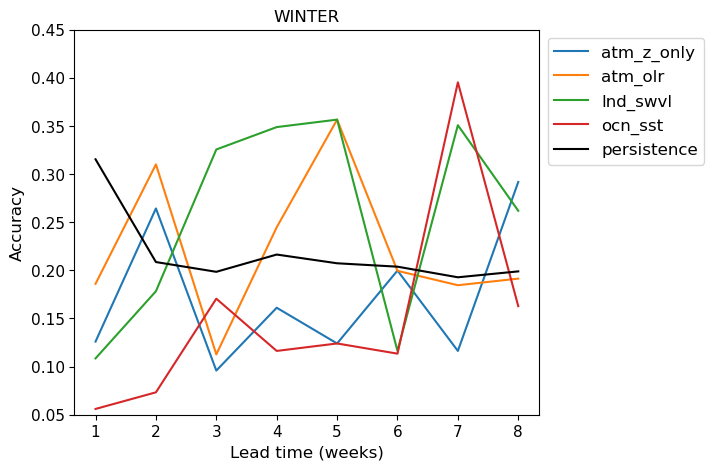

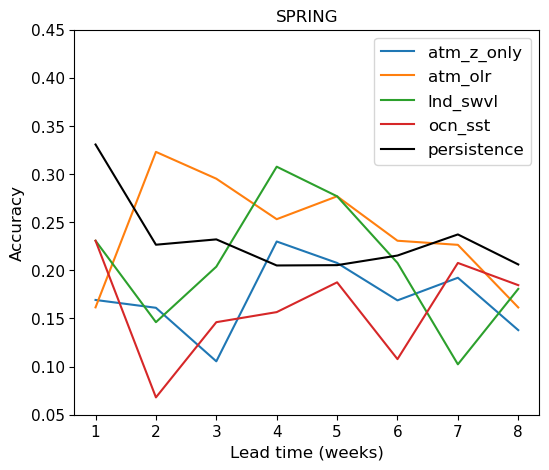

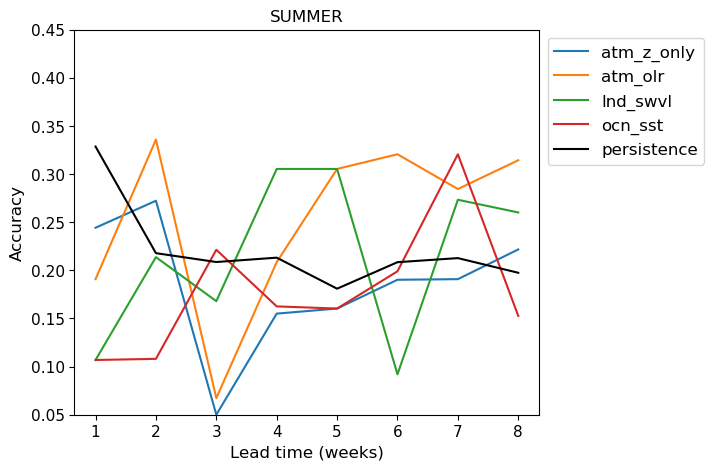

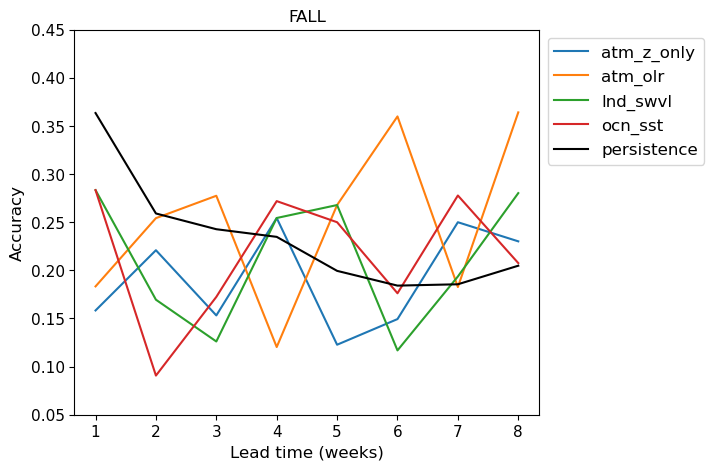

In [17]:
for iseason,season in enumerate(['winter','spring','summer','fall']):
    plt.figure(figsize=(6,5))
    # for name_input in ['atm','ocn','lnd','atm_z_only']:
    for name_input in ['atm_z_only','atm_olr','lnd_swvl','ocn_sst']:
        plt.plot(np.arange(1,9),dic_acc_seasons[name_input][1:,iseason],label = name_input)
    plt.plot(np.arange(1,9),acc_persistence_seasons[1:,iseason],label = 'persistence',color='k')
    plt.legend(bbox_to_anchor=(1., 1.),fontsize=12)
    plt.xlabel('Lead time (weeks)',fontsize=12)
    plt.ylabel('Accuracy',fontsize=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.ylim(0.05,0.45)
    plt.title(season.upper())
    plt.show()
    plt.close('all')